In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc
import numpy as np
from sympy import*

In [49]:
ex1=pd.read_csv("pos1.csv")
ex2=pd.read_csv("pos2.csv")
ex3=pd.read_csv("pos3.csv")
ex4=pd.read_csv("pos4.csv")
ex5=pd.read_csv("pos5.csv")

In [41]:
x, v, a, t = symbols("x, v, a, t")

In [68]:
ex1 = ex1.loc[(ex1.iloc[:,3] <= 1.4) & (ex1.iloc[:,3] >= 0.8)]
ex2 = ex2.loc[(ex2.iloc[:,3] <= 1.4) & (ex2.iloc[:,3] >= 0.8)].iloc[:-1]
#ex3 = ex3.loc[(ex3.iloc[:,3] <= 1.4) & (ex3.iloc[:,3] >= 0.8)]  # fucked up measurements 
ex3 = ex4.loc[(ex4.iloc[:,3] <= 1.4) & (ex4.iloc[:,3] >= 0.8)]
ex4 = ex5.loc[(ex5.iloc[:,3] <= 1.4) & (ex5.iloc[:,3] >= 0.8)]

# Equation of motion

$\frac{x}{(v*t)} = f(\frac{a*t}{v})$

In [69]:
for ex in [ex1, ex2, ex3, ex4]:
    ex['f'] = ex.iloc[:,5] / (ex.iloc[:,7] * ex.iloc[:,3])
    ex['sub'] = ex.iloc[:,9] * ex.iloc[:,3] / ex.iloc[:,7]

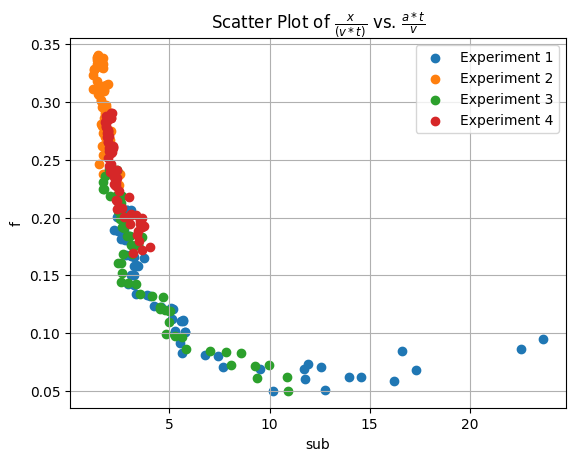

In [122]:
for num, ex in enumerate([ex1, ex2, ex3, ex4]):
    plt.scatter(ex['sub'], ex['f'], label=f"Experiment {num + 1}")
#plt.scatter(ex5['sub'], ex5['f'])
plt.xlabel('sub')
plt.ylabel('f')
plt.title(r'Scatter Plot of $\frac{x}{(v*t)}$ vs. $\frac{a*t}{v}$')
plt.legend()
plt.grid(True)
# plt.xlim(0, 20)
# plt.ylim(0, 40)
plt.show()

# Steps
1. Defining a possible function based on the plot above.
2. Performing regression analysis.
3. Calculation of mean of A and B.
4. Calculation of standard deviation of A and B.
5. Finding the best A and B to fit the data.

In [104]:
def f(x, A, B):
    return A*1/x + B
coeff = []
for ex in [ex1, ex2, ex4, ex5]:
    f1 = (ex.iloc[:,5] / (ex.iloc[:,7] * ex.iloc[:,3]))
    f2 = (ex.iloc[:,9] * ex.iloc[:,3] / ex.iloc[:,7])
    param,cov = curve_fit(f,f2,f1)
    A = unc.ufloat(param[0],np.sqrt(np.diag(cov))[0])
    B = unc.ufloat(param[1],np.sqrt(np.diag(cov))[1])
    coeff.append([A, B])

In [110]:
coeff

[[0.3993930063991311+/-0.01736309634527151,
  0.03653370651543897+/-0.0045978211741917775],
 [0.23805620590279222+/-0.030612303012227227,
  0.14990720413584038+/-0.018554080088784824],
 [0.35695689346456155+/-0.02035759878837501,
  0.08503790547768246+/-0.008864516863604165],
 [0.35695689346456155+/-0.02035759878837501,
  0.08503790547768246+/-0.008864516863604165]]

Calculating mean values of A and B coefficients.

In [107]:
Asum = 0
Bsum = 0
for i in coeff:
    Asum += i[0].n
    Bsum += i[1].n
Amean = Asum/4
Bmean = Bsum/4
Amean, Bmean

(0.3378407498077616, 0.08912918040166107)

# I don't think we need to use stanard score here

In [115]:
for i in coeff:
    print(i[0].std_score(Amean), i[1].std_score(Bmean))

-3.5450046102020307 11.439216945071278
3.2596222461640085 -3.275722829875954
-0.9390176049503466 0.46153388694837044
-0.9390176049503466 0.46153388694837044


# I would rather find standard deviation of the mean

In [116]:
Astd = 0
Bstd = 0
for i in coeff:
    Astd += (i[0].s)**2
    Bstd += (i[1].s)**2
Astd = sqrt(Astd)
Bstd = sqrt(Bstd)
Astd, Bstd

(0.0454692628845519, 0.0228594218199222)

In [136]:
A = unc.ufloat(Amean, Astd)
B = unc.ufloat(Bmean, Astd)
param_0 = [A.n, B.n]
param_1 = [A.n+A.s, B.n - B.s]
param_2 = [A.n+A.s, B.n + B.s]

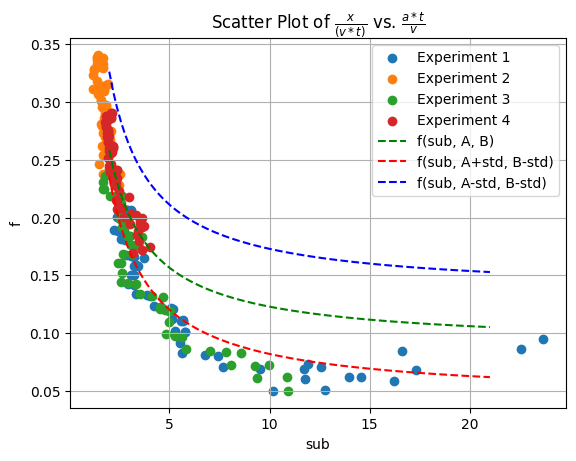

In [138]:
x_values = np.linspace(2,21,100)
for num, ex in enumerate([ex1, ex2, ex3, ex4]):
    plt.scatter(ex['sub'], ex['f'], label=f"Experiment {num + 1}")
#plt.scatter(ex5['sub'], ex5['f'])
plt.plot(x_values,f(x_values, *param_0),'g--', label="f(sub, A, B)")
plt.plot(x_values,f(x_values, *param_1),'r--', label="f(sub, A+std, B-std)")
plt.plot(x_values,f(x_values, *param_2),'b--', label="f(sub, A-std, B-std)")
plt.xlabel('sub')
plt.ylabel('f')
plt.title(r'Scatter Plot of $\frac{x}{(v*t)}$ vs. $\frac{a*t}{v}$')

plt.legend()
plt.grid(True)
# plt.xlim(0, 20)
# plt.ylim(0, 40)
plt.show()

In [139]:
A.n+A.s, B.n - B.s

(0.3833100126923135, 0.04365991751710913)

As we can see the red line fits the best, so our model is 

\begin{align*}
& \frac{x}{v * t} = f(\frac{a * t}{v}) \\
& x = v * t * (Bmean - Bstd) + (Amean + Astd) * \frac{v^2}{a} \\
& x = 0.044vt + 0.383\frac{v^2}{a}
\end{align*}